In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
# -------------------------
# 1. DEFINE SCOPE & TICKERS
# -------------------------
TICKERS = ["AAPL", "MSFT", "NFLX", "GOOGL"]
START = None # use period instead
END = None
PERIOD = '3mo' # last 3 months
INTERVAL = '1d'
RESULTS_DIR = 'results_archive'
os.makedirs(RESULTS_DIR, exist_ok=True)


In [9]:
def download_data(tickers, period='3mo', interval='1d'):
    """Download historical data for tickers using yfinance and return_archive adjusted close DataFrame."""
    df = yf.download(tickers, period=period, interval=interval, progress=False)
    # When multiple tickers, yfinance returns MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        if 'Adj Close' in df.columns.levels[0]:
            adj = df['Adj Close'].copy()
        elif 'Close' in df.columns.levels[0]:
            adj = df['Close'].copy()
        else:
            raise KeyError("Downloaded DataFrame has no 'Adj Close' or 'Close' in MultiIndex.")
    else:
        # single ticker or flattened DataFrame
        if 'Adj Close' in df.columns:
            adj = df[['Adj Close']].rename(columns={'Adj Close': tickers[0]})
        elif 'Close' in df.columns:
            adj = df[['Close']].rename(columns={'Close': tickers[0]})
        else:
            raise KeyError("Downloaded DataFrame has no 'Adj Close' or 'Close' columns.")

    adj.index = pd.to_datetime(adj.index)
    # ensure columns match requested tickers order (fill missing with NaN)
    adj = adj.reindex(columns=tickers)
    return adj


Downloaded Data:
Ticker            AAPL        MSFT       GOOGL
Date                                          
2025-02-24  246.496643  402.597839  178.827316
2025-02-25  246.436783  396.519012  175.006332
2025-02-26  239.773087  398.342682  172.322678
2025-02-27  236.720566  391.167633  168.102661
2025-02-28  241.249481  395.612152  169.878464


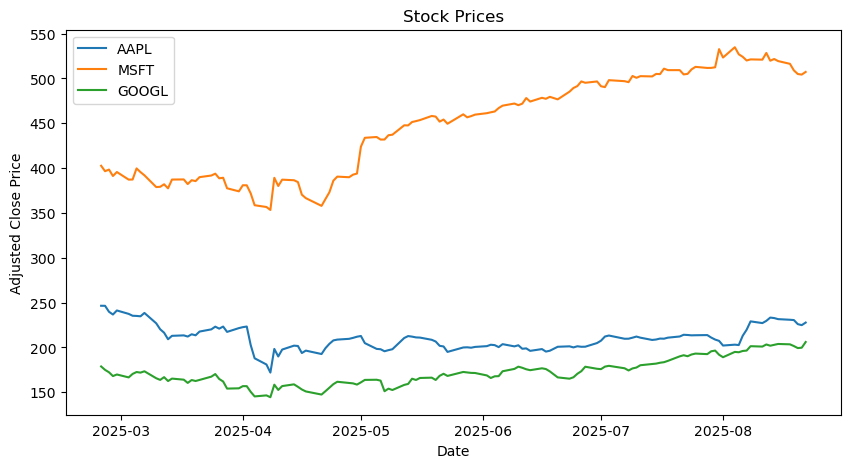

In [10]:
# -------------------------
# Example usage
# -------------------------
tickers = ["AAPL", "MSFT", "GOOGL"]   # you can change this
data = download_data(tickers, period="6mo", interval="1d")

print("Downloaded Data:")
print(data.head())

# Plot one stock as an example
plt.figure(figsize=(10,5))
plt.plot(data.index, data['AAPL'], label="AAPL")
plt.plot(data.index, data['MSFT'], label="MSFT")
plt.plot(data.index, data['GOOGL'], label="GOOGL")
plt.legend()
plt.title("Stock Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.show()

In [11]:
# -------------------------
# 3. DOWNLOAD DATA
# -------------------------
adj_close_df = download_data(TICKERS, period=PERIOD, interval=INTERVAL)

print("Downloaded Data:")
print(adj_close_df.head())

Downloaded Data:
Ticker            AAPL        MSFT         NFLX       GOOGL
Date                                                       
2025-05-23  195.048645  449.441162  1185.390015  168.266296
2025-05-27  199.983047  459.933899  1211.569946  172.690933
2025-05-28  200.192795  456.609375  1208.550049  172.151596
2025-05-29  199.723328  457.927216  1184.859985  171.652191
2025-05-30  200.622314  459.604431  1207.229980  171.532349


In [12]:
# Download last 3 months daily data
data = yf.download(tickers, period="3mo", interval="1d")

[*********************100%***********************]  3 of 3 completed


In [13]:
print(data)

Price            Close                                High              \
Ticker            AAPL       GOOGL        MSFT        AAPL       GOOGL   
Date                                                                     
2025-05-23  195.048645  168.266296  449.441162  197.475883  169.754500   
2025-05-27  199.983047  172.690933  459.933899  200.512445  172.960611   
2025-05-28  200.192795  172.151596  456.609375  202.500174  175.058081   
2025-05-29  199.723328  171.652191  457.927216  203.578952  174.209093   
2025-05-30  200.622314  171.532349  459.604431  201.731057  172.001782   
...                ...         ...         ...         ...         ...   
2025-08-18  230.889999  203.500000  516.251282  233.119995  205.270004   
2025-08-19  230.559998  201.570007  508.933350  232.869995  203.440002   
2025-08-20  226.009995  199.320007  504.890015  230.470001  201.279999   
2025-08-21  224.899994  199.750000  504.239990  226.520004  202.479996   
2025-08-22  227.759995  206.089996  50

In [14]:
# Extract Adjusted Close prices
adj_close = data["Close"]

print(adj_close.head())

Ticker            AAPL       GOOGL        MSFT
Date                                          
2025-05-23  195.048645  168.266296  449.441162
2025-05-27  199.983047  172.690933  459.933899
2025-05-28  200.192795  172.151596  456.609375
2025-05-29  199.723328  171.652191  457.927216
2025-05-30  200.622314  171.532349  459.604431


In [15]:
# -------------------------
# 2. DOWNLOAD HISTORICAL DATA
# -------------------------
df = yf.download(
    tickers=TICKERS,
    period=PERIOD,
    interval=INTERVAL,
    group_by='ticker',
    auto_adjust=True
)



[*********************100%***********************]  4 of 4 completed


In [16]:
print(df.columns)
print(df.head())

MultiIndex([('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume'),
            ( 'NFLX',   'Open'),
            ( 'NFLX',   'High'),
            ( 'NFLX',    'Low'),
            ( 'NFLX',  'Close'),
            ( 'NFLX', 'Volume'),
            ( 'MSFT',   'Open'),
            ( 'MSFT',   'High'),
            ( 'MSFT',    'Low'),
            ( 'MSFT',  'Close'),
            ( 'MSFT', 'Volume')],
           names=['Ticker', 'Price'])
Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2025-05-23  168.855579  169.754500  167.686996  168.266296  35211400   
2025-05-27  1

In [17]:
# -------------------------
# Utility functions
# -------------------------
def compute_basic_features(adj):
    """Compute returns, moving averages, volatility and other features for each ticker."""
    df = adj.copy()

    # Daily returns
    returns = df.pct_change().rename(columns=lambda x: f"{x}_return")

    # Moving averages
    ma_windows = [5, 10, 20]
    ma_feats = []
    for w in ma_windows:
        ma = df.rolling(window=w).mean().rename(columns=lambda x: f"{x}_ma{w}")
        ma_feats.append(ma)

    # Volatility
    vol = df.pct_change().rolling(window=10).std().rename(columns=lambda x: f"{x}_vol10")

    # Combine features
    features = pd.concat([df] + ma_feats + [returns, vol], axis=1)
    features = features.dropna()

    return features


In [18]:
def add_technical_indicators(features, tickers):
    """Add RSI and MACD for each ticker (simple implementations)."""
    for t in tickers:
        price = features[t]
# RSI
        delta = price.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.ewm(com=13).mean()
        roll_down = down.ewm(com=13).mean()
        # avoid division by zero
        roll_down = roll_down.replace(0, np.nan)
        rs = roll_up / roll_down
        rsi = 100.0 - (100.0 / (1.0 + rs))
        features[f"{t}_rsi"] = rsi


# MACD
        ema12 = price.ewm(span=12, adjust=False).mean()
        ema26 = price.ewm(span=26, adjust=False).mean()
        macd = ema12 - ema26
        signal = macd.ewm(span=9, adjust=False).mean()
        features[f"{t}_macd"] = macd
        features[f"{t}_macd_signal"] = signal

    features = features.dropna()
    return features


In [19]:
def plot_price_trends(adj):
    plt.figure(figsize=(12,6))
    adj.plot(title='Adjusted Close Price - Last 3 months')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'price_trends.png'))
    plt.close()
    return adj


In [20]:
def plot_correlation(adj):
    returns = adj.pct_change().dropna()
    corr = returns.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Returns Correlation')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'returns_correlation.png'))
    plt.close()

    return corr



In [21]:
# -------------------------
# 6. Modeling helpers
# -------------------------
from sklearn.metrics import mean_squared_error
import numpy as np

def train_classical_models(X_train, y_train, X_test, y_test, ticker_label):

    results = {}


    models = {
        'LinearRegression': LinearRegression(),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }


    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        results[name] = {'model': model, 'rmse': rmse, 'mae': mae, 'preds': preds}
        print(f"{name} RMSE: {rmse:.4f}, MAE: {mae:.4f}")
#save model
        joblib.dump(model, os.path.join(RESULTS_DIR, f'{ticker_label}_{name}.joblib'))

    return results





def prepare_lstm_data(series, seq_len=20):
    """Return X,y for LSTM where X shape = (n_samples, seq_len, 1)"""
    arr = np.array(series).flatten()
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len])
    X = np.array(X)
    y = np.array(y)
    if X.size == 0:
        return np.empty((0, seq_len, 1)), np.empty((0,))
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y





def build_lstm(seq_len=20):
    model = Sequential()
    model.add(LSTM(64, input_shape=(seq_len,1), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [22]:
print(build_lstm)

<function build_lstm at 0x0000024B8D6A0D60>


In [23]:
# -------------------------
# Visualization functions
# -------------------------
def plot_price_matrix(adj):
    """Plot a matrix of all tickers with subplots for visual comparison."""
    n = len(adj.columns)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=True)
    for i, t in enumerate(adj.columns):
        axes[i].plot(adj.index, adj[t], label=t, color=f"C{i}")
        axes[i].set_ylabel("Price")
        axes[i].legend(loc='upper left')
    plt.xlabel("Date")
    plt.suptitle("Price Trend Matrix")
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.savefig(os.path.join(RESULTS_DIR, 'price_matrix.png'))
    plt.close()

def plot_predictions(y_test, preds_dict, ticker_label):
    """Plot predictions vs actual values for each model."""
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='black')
    for name, preds in preds_dict.items():
        plt.plot(y_test.index, preds, label=name)
    plt.title(f"Prediction vs Actual - {ticker_label}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'{ticker_label}_predictions.png'))
    plt.close()

def plot_residuals(y_test, preds_dict, ticker_label):
    """Plot residuals for each model."""
    plt.figure(figsize=(12,6))
    for name, preds in preds_dict.items():
        residuals = y_test.values - preds
        sns.kdeplot(residuals, label=name, fill=True)
    plt.title(f"Residual Distribution - {ticker_label}")
    plt.xlabel("Residual")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'{ticker_label}_residuals.png'))
    plt.close()


In [24]:
# -------------------------
# 2-5 Data collection -> EDA -> Feature engineering
# -------------------------

# -------------------------
# Main workflow
# -------------------------

def main_workflow(tickers=TICKERS, period=PERIOD, interval=INTERVAL):
    print('Downloading data...')
    adj = download_data(tickers, period=period, interval=interval)
    adj.to_csv(os.path.join(RESULTS_DIR, 'adj_close.csv'))



    print('Plotting price trends...')
    plot_price_trends(adj)
    adj = adj.pct_change().dropna()

    print('Plotting price matrix...')
    plot_price_matrix(adj)


    print('Correlation analysis...')
    plot_correlation(adj)

    print('Computing features...')
    features = compute_basic_features(adj)
    features = add_technical_indicators(features, tickers)
    features.to_csv(os.path.join(RESULTS_DIR, 'features.csv'))


# Show a quick EDA: last rows
    print('Feature sample:')
    print(features.tail())

    # -------------------------
# Modeling for each ticker: predict next-day adjusted close
# We'll create a supervised learning dataset using lag features from other tickers too.
# -------------------------
    summary = {}
    for t in tickers:
        print('\n\nProcessing ticker:', t)
        df = features[[c for c in features.columns if c.startswith(t) or c.endswith('_return') or c.endswith('_vol10') or '_macd' in c or '_rsi' in c]].copy()
# target = next-day adjusted close
        df[f'{t}_target'] = df[t].shift(-1)
        df = df.dropna()


# create lag features for the ticker itself
        lags = [1,2,3]
        for l in lags:
            df[f'{t}_lag{l}'] = df[t].shift(l)
        df = df.dropna()

        features_cols = [c for c in df.columns if c != f'{t}_target']
        X = df[features_cols]
        y = df[f'{t}_target']

        # train-test split (time based)
        split = int(len(df)*0.8)

        if split < 1 or len(df) - split < 1:
            print(f"Not enough data for ticker {t} to perform train/test split. Skipping.")
            continue

        X_train, X_test = X.iloc[:split], X.iloc[split:]
        y_train, y_test = y.iloc[:split], y.iloc[split:]

        # Standardize features for linear models
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        joblib.dump(scaler, os.path.join(RESULTS_DIR, f'{t}_scaler.joblib'))

        classical_results = train_classical_models(X_train_s, y_train, X_test_s, y_test, ticker_label=t)


        # Baseline persistence (predict today's price as tomorrow's)
        preds_persist = X_test[f'{t}_lag1'].values  # lag1 is today's price
        mse_p = mean_squared_error(y_test, preds_persist)
        rmse_p = np.sqrt(mse_p)
        mae_p = mean_absolute_error(y_test, preds_persist)

        # LSTM: use only the price series (scaled between 0 and 1)
        series = df[t].copy()
        scaler_mm = MinMaxScaler()
        series_scaled = scaler_mm.fit_transform(series.values.reshape(-1,1)).flatten()
        seq_len = 20
        X_l, y_l = prepare_lstm_data(pd.Series(series_scaled), seq_len=seq_len)
        # train-test split for sequences
        split_l = int(len(X_l)*0.8)
        Xl_train, Xl_test = X_l[:split_l], X_l[split_l:]
        yl_train, yl_test = y_l[:split_l], y_l[split_l:]

        lstm = build_lstm(seq_len=seq_len)
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = lstm.fit(Xl_train, yl_train, validation_data=(Xl_test, yl_test), epochs=50, batch_size=16, callbacks=[es], verbose=0)


# predict and invert scaling
        preds_l = lstm.predict(Xl_test).flatten()
        preds_l_inv = scaler_mm.inverse_transform(preds_l.reshape(-1,1)).flatten()
        y_l_inv = scaler_mm.inverse_transform(yl_test.reshape(-1,1)).flatten()
        mse_l = mean_squared_error(y_l_inv, preds_l_inv)
        rmse_l = np.sqrt(mse_l)
        mae_l = mean_absolute_error(y_l_inv, preds_l_inv)


        # Save LSTM
        lstm.save(os.path.join(RESULTS_DIR, f'{t}_lstm.h5'))


# Collect summary stats
        summary[t] = {
            'baseline_rmse': rmse_p, 'baseline_mae': mae_p,
            'linear_rmse': classical_results['LinearRegression']['rmse'],
            'rf_rmse': classical_results['RandomForest']['rmse'],
            'gbr_rmse': classical_results['GradientBoosting']['rmse'],
            'lstm_rmse': rmse_l
        }



        # Save predictions CSV for comparison
        out = pd.DataFrame({
            'y_test': y_test.values,
            'persist_pred': preds_persist,
            'lr_pred': classical_results['LinearRegression']['preds'],
            'rf_pred': classical_results['RandomForest']['preds'],
            'gbr_pred': classical_results['GradientBoosting']['preds'],
        }, index=y_test.index)
        out.to_csv(os.path.join(RESULTS_DIR, f'{t}_preds.csv'))


        print(f"Completed {t} - baseline RMSE: {rmse_p:.6f}, LR RMSE: {classical_results['LinearRegression']['rmse']:.6f}, RF RMSE: {classical_results['RandomForest']['rmse']:.6f}, LSTM RMSE: {rmse_l:.6f}")

        # -------------------------
# Visualization: Actual vs Predicted Prices
# -------------------------

        # Align lengths to avoid ValueError
        min_len = min(
            len(y_test),
            len(preds_persist),
            len(classical_results['LinearRegression']['preds']),
            len(classical_results['RandomForest']['preds']),
            len(classical_results['GradientBoosting']['preds']),
            len(preds_l_inv)
        )


        x_index = y_test.index[-min_len:]
        y_actual = y_test.values[-min_len:]


        preds_dict = {
            'Persistence': preds_persist[-min_len:],
            'LinearRegression': classical_results['LinearRegression']['preds'][-min_len:],
            'RandomForest': classical_results['RandomForest']['preds'][-min_len:],
            'GradientBoosting': classical_results['GradientBoosting']['preds'][-min_len:],
            'LSTM': preds_l_inv[-min_len:]
        }

        plt.figure(figsize=(12,6))
        plt.plot(x_index, y_actual, label='Actual', color='black')
        for name, preds in preds_dict.items():
            plt.plot(x_index, preds, label=name)
        plt.title(f'{t} - Actual vs Predicted Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, f'{t}_predictions.png'))
        plt.show()



        # summary table
        summary_df = pd.DataFrame(summary).T
        summary_df.to_csv(os.path.join(RESULTS_DIR, 'models_summary.csv'))
        print('\nModel summary:')
        print(summary_df)


Plotting price trends...
Plotting price matrix...
Correlation analysis...
Computing features...
Feature sample:
Ticker          AAPL      MSFT      NFLX     GOOGL  AAPL_ma5  MSFT_ma5  \
Date                                                                     
2025-08-18 -0.003023 -0.005902  0.004956 -0.001962  0.003281 -0.001744   
2025-08-19 -0.001429 -0.014175 -0.024850 -0.009484  0.000821 -0.007442   
2025-08-20 -0.019735 -0.007945 -0.000239 -0.011162 -0.006331 -0.005759   
2025-08-21 -0.004911 -0.001287 -0.006302  0.002157 -0.006842 -0.006746   
2025-08-22  0.012717  0.005930 -0.001293  0.031740 -0.003276 -0.004676   

Ticker      NFLX_ma5  GOOGL_ma5  AAPL_ma10  MSFT_ma10  ...  AAPL_macd_signal  \
Date                                                   ...                     
2025-08-18  0.004435   0.002495   0.013101  -0.003480  ...          0.002610   
2025-08-19 -0.001680  -0.001730   0.013170  -0.003424  ...          0.002152   
2025-08-20  0.001674  -0.002605   0.006106  -0.00

Completed AAPL - baseline RMSE: 0.017937, LR RMSE: 0.162318, RF RMSE: 0.010249, LSTM RMSE: 0.007167


<Figure size 1200x600 with 0 Axes>

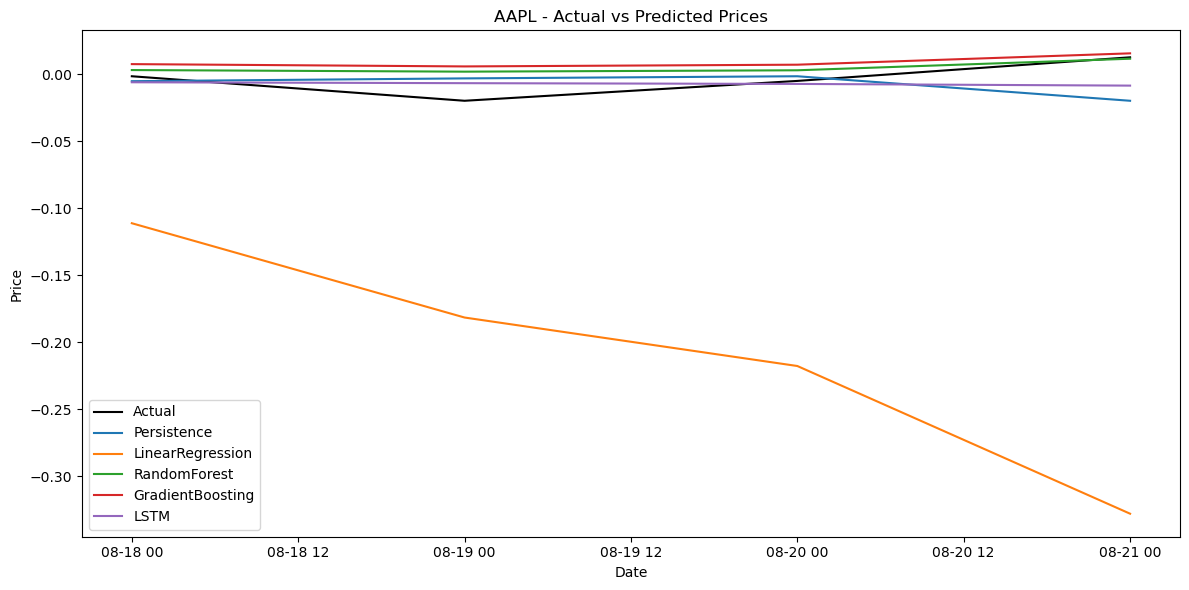


Model summary:
      baseline_rmse  baseline_mae  linear_rmse   rf_rmse  gbr_rmse  lstm_rmse
AAPL       0.017937      0.014465     0.162318  0.010249  0.012675   0.007167


Processing ticker: MSFT
LinearRegression RMSE: 0.1665, MAE: 0.1276
RandomForest RMSE: 0.0154, MAE: 0.0138
GradientBoosting RMSE: 0.0167, MAE: 0.0160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


Completed MSFT - baseline RMSE: 0.011492, LR RMSE: 0.166543, RF RMSE: 0.015405, LSTM RMSE: 0.004917


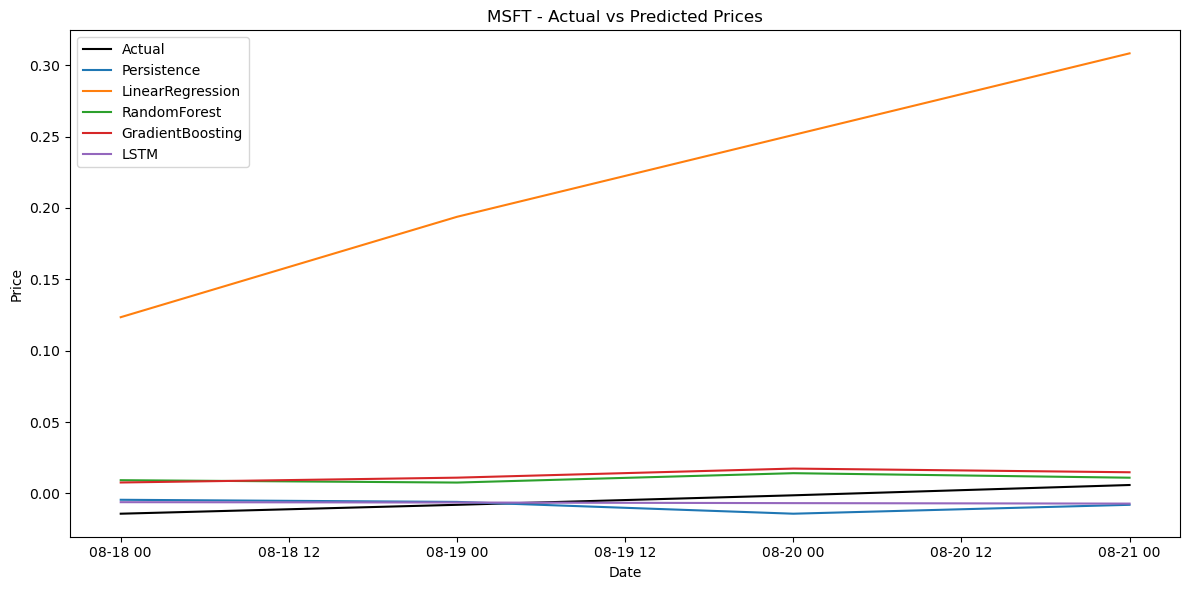


Model summary:
      baseline_rmse  baseline_mae  linear_rmse   rf_rmse  gbr_rmse  lstm_rmse
AAPL       0.017937      0.014465     0.162318  0.010249  0.012675   0.007167
MSFT       0.011492      0.010821     0.166543  0.015405  0.016715   0.004917


Processing ticker: NFLX
LinearRegression RMSE: 0.0670, MAE: 0.0563
RandomForest RMSE: 0.0168, MAE: 0.0144
GradientBoosting RMSE: 0.0214, MAE: 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


Completed NFLX - baseline RMSE: 0.019314, LR RMSE: 0.066980, RF RMSE: 0.016816, LSTM RMSE: 0.011494


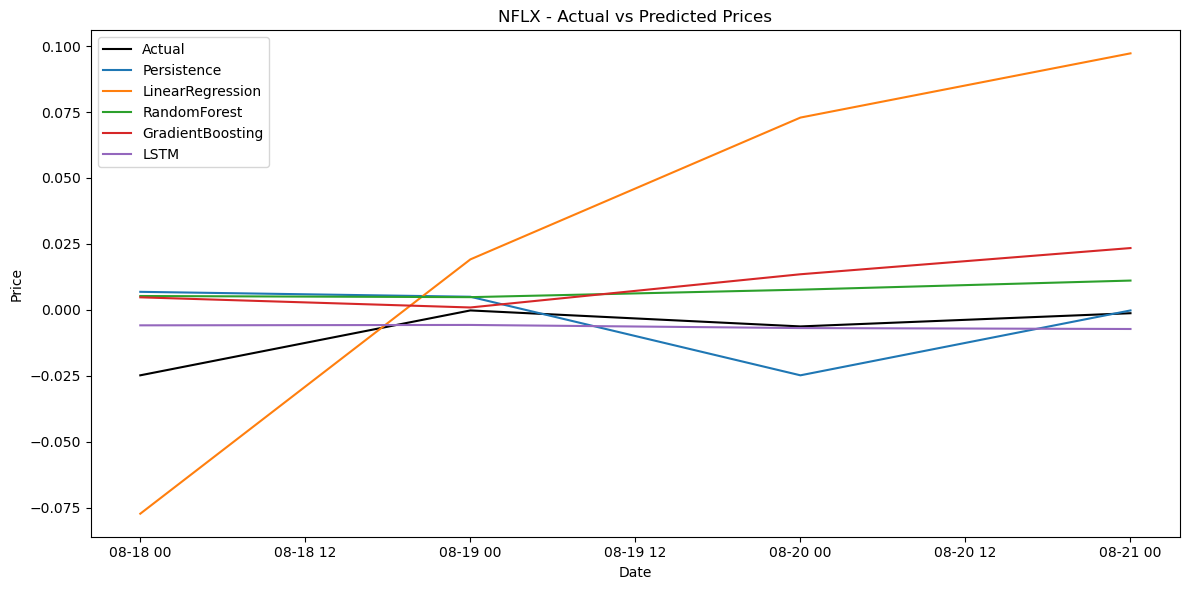


Model summary:
      baseline_rmse  baseline_mae  linear_rmse   rf_rmse  gbr_rmse  lstm_rmse
AAPL       0.017937      0.014465     0.162318  0.010249  0.012675   0.007167
MSFT       0.011492      0.010821     0.166543  0.015405  0.016715   0.004917
NFLX       0.019314      0.016937     0.066980  0.016816  0.021419   0.011494


Processing ticker: GOOGL
LinearRegression RMSE: 0.0394, MAE: 0.0366
RandomForest RMSE: 0.0140, MAE: 0.0114
GradientBoosting RMSE: 0.0144, MAE: 0.0128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


Completed GOOGL - baseline RMSE: 0.017713, LR RMSE: 0.039393, RF RMSE: 0.014006, LSTM RMSE: 0.005486


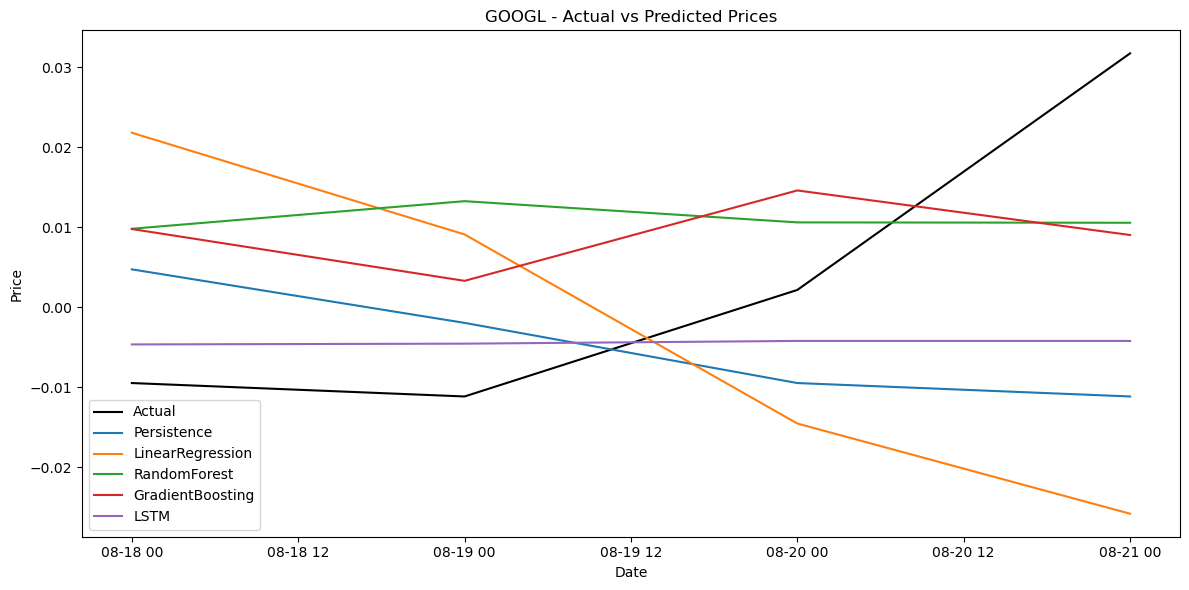


Model summary:
       baseline_rmse  baseline_mae  linear_rmse   rf_rmse  gbr_rmse  lstm_rmse
AAPL        0.017937      0.014465     0.162318  0.010249  0.012675   0.007167
MSFT        0.011492      0.010821     0.166543  0.015405  0.016715   0.004917
NFLX        0.019314      0.016937     0.066980  0.016816  0.021419   0.011494
GOOGL       0.017713      0.013473     0.039393  0.014006  0.014410   0.005486


In [25]:
if __name__ == '__main__':
    main_workflow()

In [26]:
import os
print(os.path.abspath(RESULTS_DIR))

c:\Users\Tanisha\Downloads\stock-app\results_archive


All outputs are in: c:\Users\Tanisha\Downloads\stock-app\results_archive

CSV Files Preview:

--- AAPL_preds.csv ---


,Date,y_test,persist_pred,lr_pred,rf_pred,gbr_pred
0,2025-08-12,0.016024,-0.008337,-0.040524,0.001992,0.005097
1,2025-08-13,-0.002357,0.010872,-0.009561,0.003463,0.005554
2,2025-08-14,-0.005112,0.016024,-0.049346,0.000157,0.006014
3,2025-08-15,-0.003023,-0.002357,-0.080210,0.001862,0.006158
4,2025-08-18,-0.001429,-0.005112,-0.111149,0.003197,0.007630




--- adj_close.csv ---


,Date,AAPL,MSFT,NFLX,GOOGL
0,2025-05-23,195.048645,449.441162,1185.390015,168.266296
1,2025-05-27,199.983047,459.933899,1211.569946,172.690933
2,2025-05-28,200.192795,456.609375,1208.550049,172.151596
3,2025-05-29,199.723328,457.927216,1184.859985,171.652191
4,2025-05-30,200.622314,459.604431,1207.229980,171.532349




--- features.csv ---


,Date,AAPL,MSFT,NFLX,GOOGL,AAPL_ma5,MSFT_ma5,NFLX_ma5,GOOGL_ma5,AAPL_ma10,...,AAPL_macd_signal,MSFT_rsi,MSFT_macd,MSFT_macd_signal,NFLX_rsi,NFLX_macd,NFLX_macd_signal,GOOGL_rsi,GOOGL_macd,GOOGL_macd_signal
0,2025-06-26,-0.002778,0.010523,0.024638,0.016757,0.004506,0.007097,0.013490,0.000505,0.001166,...,0.000358,61.924040,-0.000085,-0.000069,55.984605,-0.001104,-0.000520,65.834771,0.001429,0.000463
1,2025-06-27,0.000398,-0.003035,0.012589,0.028754,0.000088,0.007673,0.014516,0.013964,0.000994,...,0.000541,24.984808,-0.000978,-0.000251,44.338098,-0.001454,-0.000707,79.417960,0.002621,0.000895
2,2025-06-30,0.020340,0.002964,0.012100,-0.012883,0.003659,0.004663,0.013342,0.013128,0.004409,...,0.001044,41.589195,-0.001189,-0.000438,43.938586,-0.001751,-0.000915,31.947539,0.000204,0.000756
3,2025-07-01,0.012916,-0.010776,-0.034000,-0.002213,0.007433,0.000817,0.002462,0.010772,0.004698,...,0.001602,26.902614,-0.002436,-0.000838,22.947237,-0.005641,-0.001860,41.583727,-0.000841,0.000437
4,2025-07-02,0.022231,-0.001951,-0.006756,0.015924,0.010621,-0.000455,0.001714,0.009268,0.008322,...,0.002308,41.252236,-0.002682,-0.001207,40.912561,-0.006451,-0.002778,53.608487,-0.000203,0.000309




--- GOOGL_preds.csv ---


,Date,y_test,persist_pred,lr_pred,rf_pred,gbr_pred
0,2025-08-12,-0.006787,-0.002085,0.019696,-0.002379,-0.006348
1,2025-08-13,0.004852,0.011642,0.059234,0.009515,-0.007506
2,2025-08-14,0.004730,-0.006787,0.053728,0.000039,-0.010454
3,2025-08-15,-0.001962,0.004852,0.035091,0.002238,-0.007172
4,2025-08-18,-0.009484,0.004730,0.021811,0.009808,0.009775




--- models_summary.csv ---


,Unnamed: 0,baseline_rmse,baseline_mae,linear_rmse,rf_rmse,gbr_rmse,lstm_rmse
0,AAPL,0.017937,0.014465,0.162318,0.010249,0.012675,0.007167
1,MSFT,0.011492,0.010821,0.166543,0.015405,0.016715,0.004917
2,NFLX,0.019314,0.016937,0.066980,0.016816,0.021419,0.011494
3,GOOGL,0.017713,0.013473,0.039393,0.014006,0.014410,0.005486




--- MSFT_preds.csv ---


,Date,y_test,persist_pred,lr_pred,rf_pred,gbr_pred
0,2025-08-12,-0.016363,-0.000517,-0.009589,0.006352,0.003066
1,2025-08-13,0.003650,0.014317,0.020250,0.007286,0.010696
2,2025-08-14,-0.004421,-0.016363,0.020322,0.004898,0.012346
3,2025-08-15,-0.005902,0.003650,0.072531,0.009005,0.010133
4,2025-08-18,-0.014175,-0.004421,0.123483,0.009299,0.007686




--- NFLX_preds.csv ---


,Date,y_test,persist_pred,lr_pred,rf_pred,gbr_pred
0,2025-08-12,-0.017008,0.005505,-0.048884,-0.006619,0.004588
1,2025-08-13,0.021687,0.005721,0.018881,-0.002496,-0.006831
2,2025-08-14,0.006818,-0.017008,-0.044390,-0.010056,-0.013973
3,2025-08-15,0.004956,0.021687,-0.109592,0.002369,0.013858
4,2025-08-18,-0.024850,0.006818,-0.077343,0.005233,0.004736




PNG Files Preview:

--- AAPL_predictions.png ---


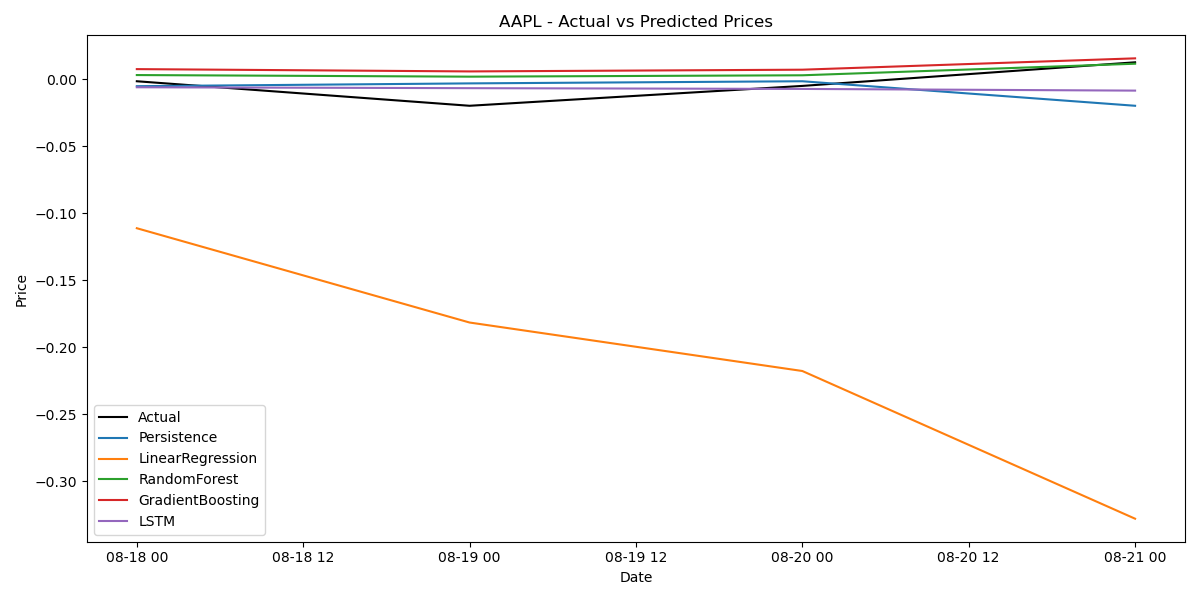

--- GOOGL_predictions.png ---


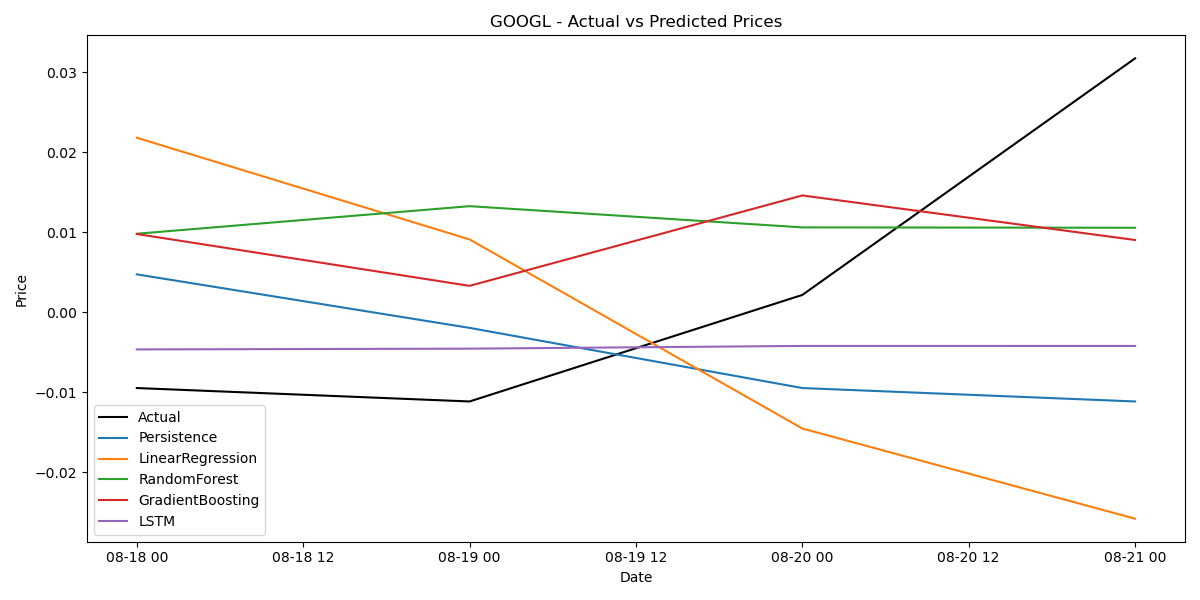

--- MSFT_predictions.png ---


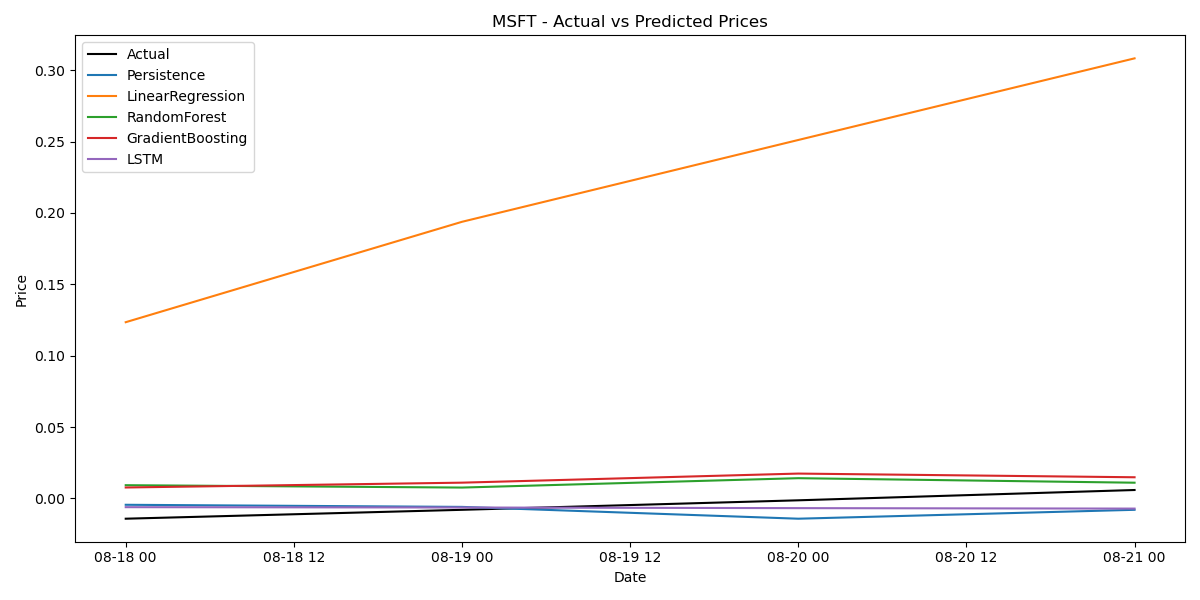

--- NFLX_predictions.png ---


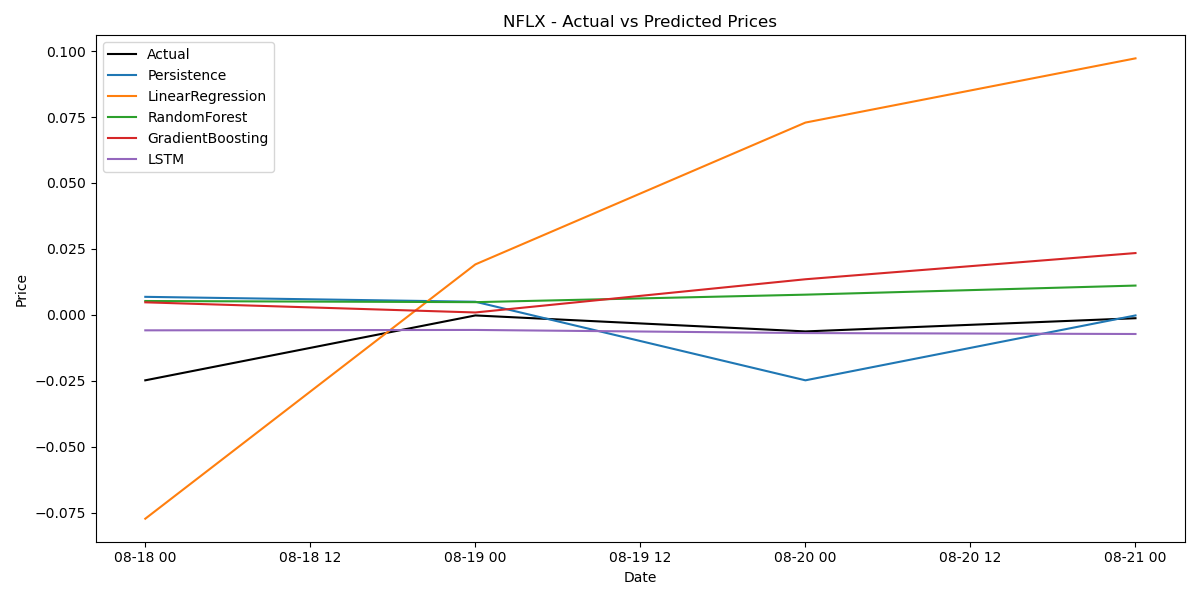

--- price_matrix.png ---


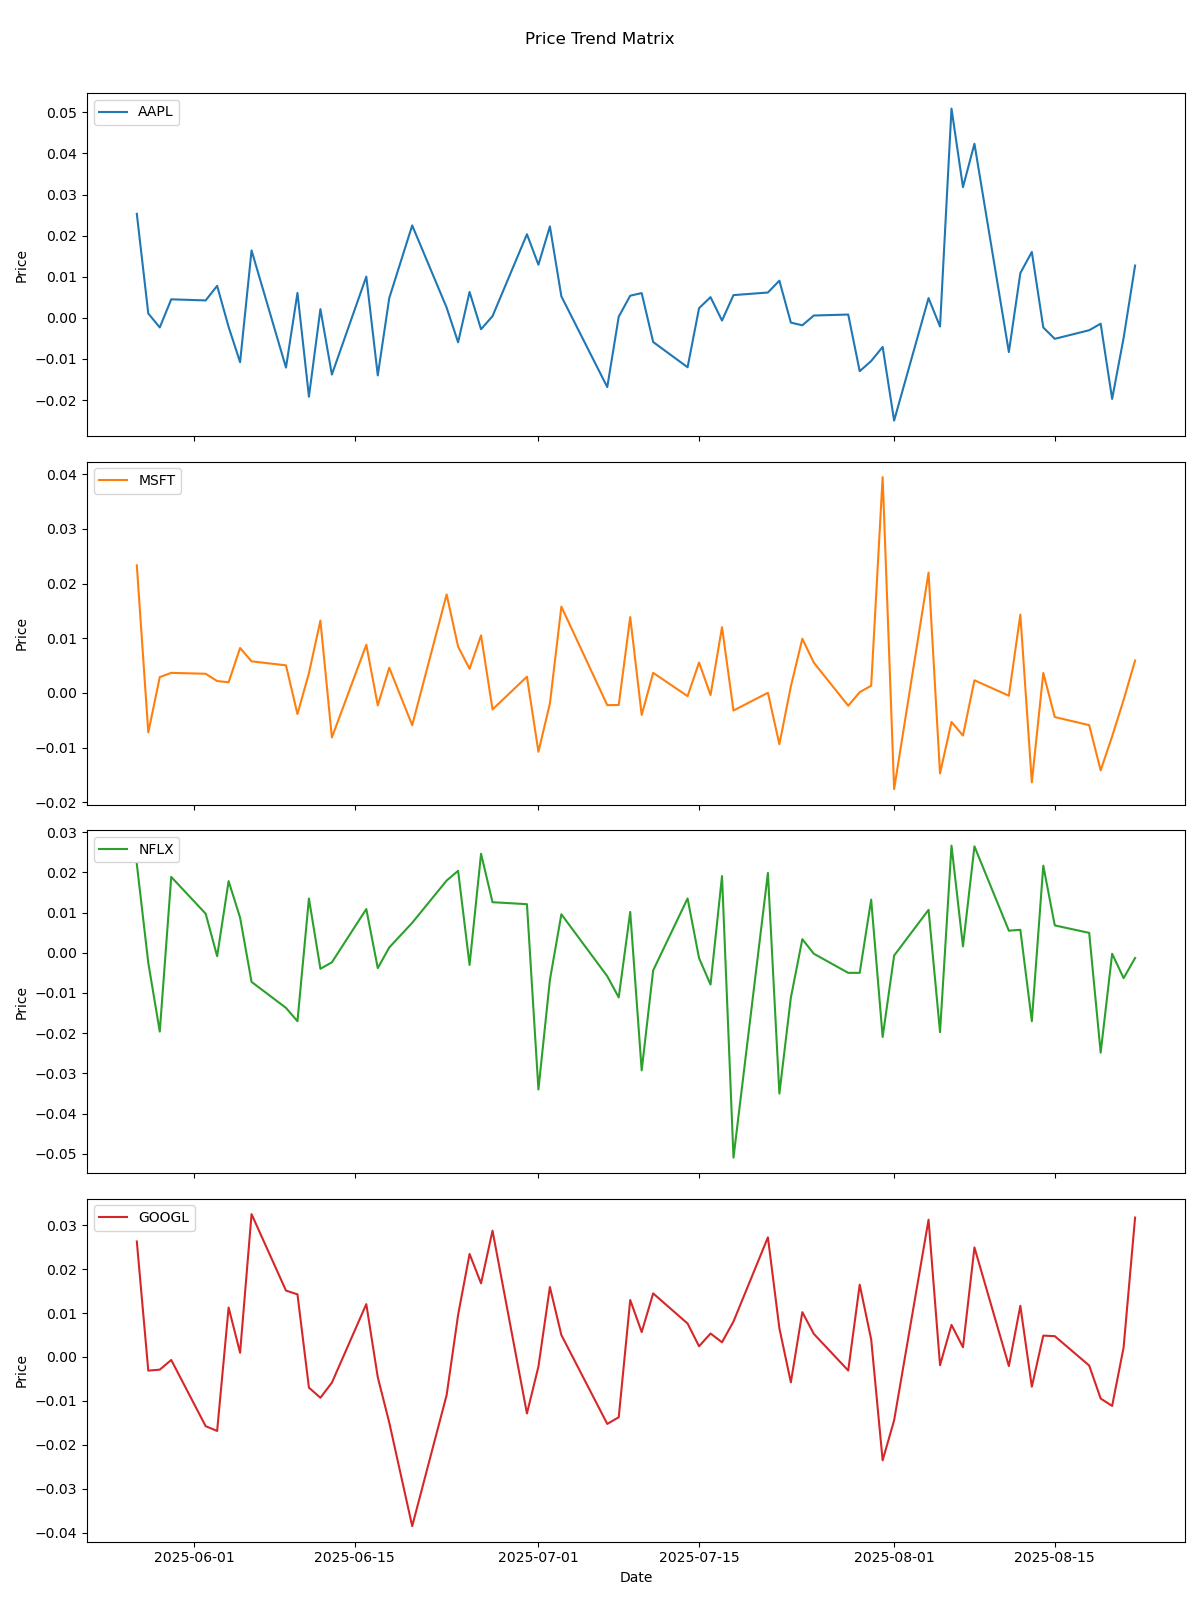

--- price_trends.png ---


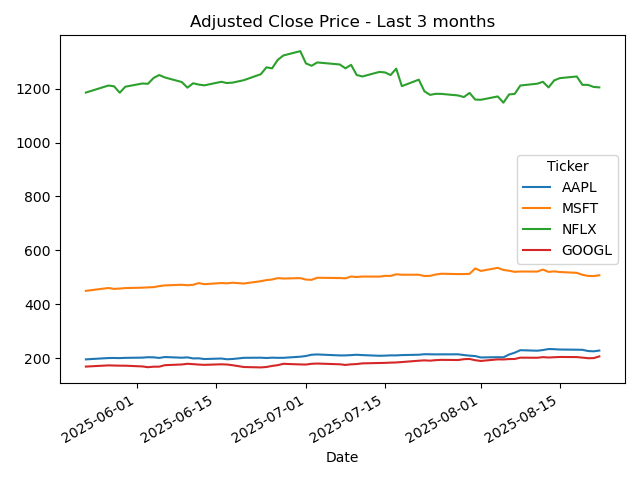

--- returns_correlation.png ---


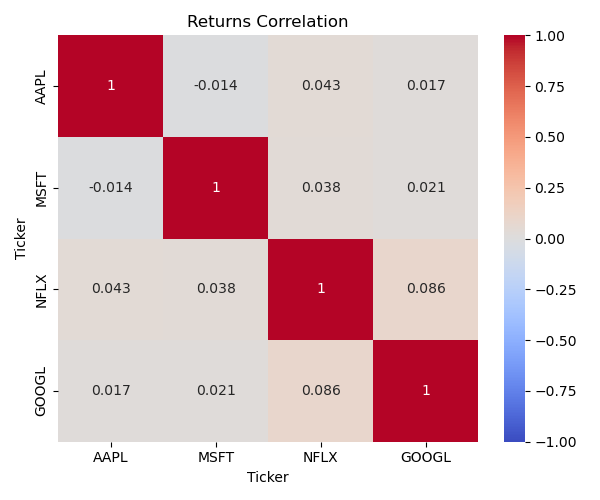

In [27]:
import os
import pandas as pd
from IPython.display import display
from PIL import Image

# Full path to the results folder
results_path = os.path.abspath('results_archive')
print(f"All outputs are in: {results_path}\n")

# List all files
files = os.listdir(results_path)
csv_files = [f for f in files if f.endswith('.csv')]
png_files = [f for f in files if f.endswith('.png')]

# -------------------------
# Display CSV heads
# -------------------------
print("CSV Files Preview:\n")
for csv in csv_files:
    print(f"--- {csv} ---")
    df = pd.read_csv(os.path.join(results_path, csv))
    display(df.head())
    print("\n")

# -------------------------
# Display PNGs
# -------------------------
print("PNG Files Preview:\n")
for png in png_files:
    print(f"--- {png} ---")
    img = Image.open(os.path.join(results_path, png))
    display(img)


In [51]:
%pip install numpy==2.2.0


   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 4.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.6 MB 4.6 MB/s eta 0:00:03
   ------- -------------------------------- 2.4/12.6 MB 4.3 MB/s eta 0:00:03
   ---------- ----------------------------- 3.4/12.6 MB 4.4 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.6 MB 4.2 MB/s eta 0:00:02
   --------------- ------------------------ 5.0/12.6 MB 4.0 MB/s eta 0:00:02
   ----------------- ---------------------- 5.5/12.6 MB 3.9 MB/s eta 0:00:02
   ------------------- -------------------- 6.3/12.6 MB 3.8 MB/s eta 0:00:02
   --------------------- ------------------ 6.8/12.6 MB 3.7 MB/s eta 0:00:02
   ---------------------- ----------------- 7.1/12.6 MB 3.4 MB/s eta 0:00:02
   ----------------------- ---------------- 7.3/12.6 MB 3.2 MB/s eta 0:00:02
   ------------------------ --------------- 7.9/12.6 MB 3.0 MB/s eta 0:00:02
   ---

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [52]:
%pip install --upgrade --force-reinstall shap

  Using cached shap-0.48.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached llvmlite-0.44.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached python_da

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [54]:
print("NumPy version:", numpy.__version__)

NumPy version: 2.3.1


In [55]:
%pip uninstall numpy -y
%pip install numpy==2.2.0


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


  Using cached numpy-2.2.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.0-cp313-cp313-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
%pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 3.6 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 3.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.8/2.8 MB 1.7 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 1.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.8 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.9 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.9 MB/s eta 0:00:00
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   -------

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import numpy
import shap

print("NumPy version:", numpy.__version__)
print("SHAP version:", shap.__version__)


c:\Users\Tanisha\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NumPy version: 2.1.3
SHAP version: 0.48.0


In [7]:
# -------------------------
# 0. Install / Import additional libraries for next steps
# -------------------------
%pip install shap streamlit -q

import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
# -------------------------
# 1. Hyperparameter tuning for RF / GBR with TimeSeriesSplit
# -------------------------
def tune_classical_model(X_train, y_train, model_type='RandomForest'):
    tscv = TimeSeriesSplit(n_splits=5)
    if model_type == 'RandomForest':
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    elif model_type == 'GradientBoosting':
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    gs = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    gs.fit(X_train, y_train)
    print(f"Best params for {model_type}: {gs.best_params_}")
    return gs.best_estimator_

In [30]:
# -------------------------
# 2. Feature importance using SHAP
# -------------------------
def shap_feature_importance(model, X_train, max_display=10):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, max_display=max_display, show=True)


In [31]:
# -------------------------
# 3. Multi-variate LSTM prep
# -------------------------
def prepare_multivariate_lstm(features, target_col, seq_len=20):
    data = features.values
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, features.columns.get_loc(target_col)])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [32]:
# -------------------------
# 4. Backtesting simple trading strategy
# -------------------------
def backtest_strategy(y_true, y_pred):
    signals = np.where(y_pred > y_true, 1, -1)  # Buy if predicted > today, else sell
    returns = np.diff(y_true) / y_true[:-1]  # daily returns
    strategy_returns = signals[:-1] * returns
    cumulative = np.cumprod(1 + strategy_returns) - 1
    plt.figure(figsize=(10,5))
    plt.plot(cumulative, label="Strategy Cumulative Returns")
    plt.title("Backtest Cumulative Returns")
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()
    return cumulative

In [33]:
print(backtest_strategy)

<function backtest_strategy at 0x0000024B99D66FC0>


In [34]:
# -------------------------
# 5. Streamlit skeleton (for Colab + ngrok)
# -------------------------
streamlit_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title('Stock Price Predictions Dashboard')
uploaded_file = st.file_uploader("Upload predictions CSV", type="csv")
if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.write(df.head())
    st.line_chart(df[['y_test', 'lr_pred', 'rf_pred', 'gbr_pred', 'persist_pred']])
"""

with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit dashboard saved as app.py. Run: !streamlit run app.py --server.port 8501 --server.address 0.0.0.0")

Streamlit dashboard saved as app.py. Run: !streamlit run app.py --server.port 8501 --server.address 0.0.0.0


In [35]:
# -------------------------
# 6. Additional improvements
# -------------------------
# - Handle missing dates / holidays in the dataset
# - Ensemble predictions example
def ensemble_predictions(preds_dict, weights=None):
    models = list(preds_dict.keys())
    n = len(models)
    if weights is None:
        weights = [1/n]*n
    ensemble = np.zeros_like(preds_dict[models[0]])
    for w, m in zip(weights, models):
        ensemble += w * preds_dict[m]
    return ensemble

**Single Colab cell you can run after your workflow, using your saved CSVs and PNGs from the results_archive folder. It demonstrates all 6 next steps interactively without touching your workflow.**

Best params for RandomForest: {'max_depth': 5, 'n_estimators': 100}
Best params for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


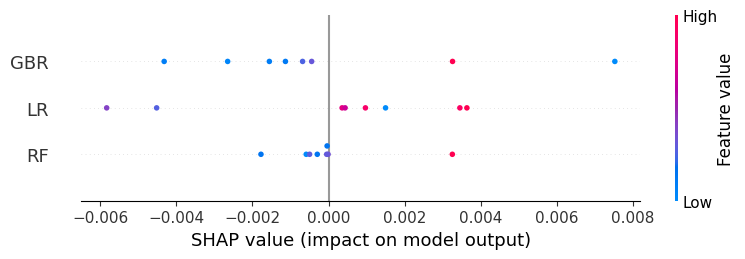

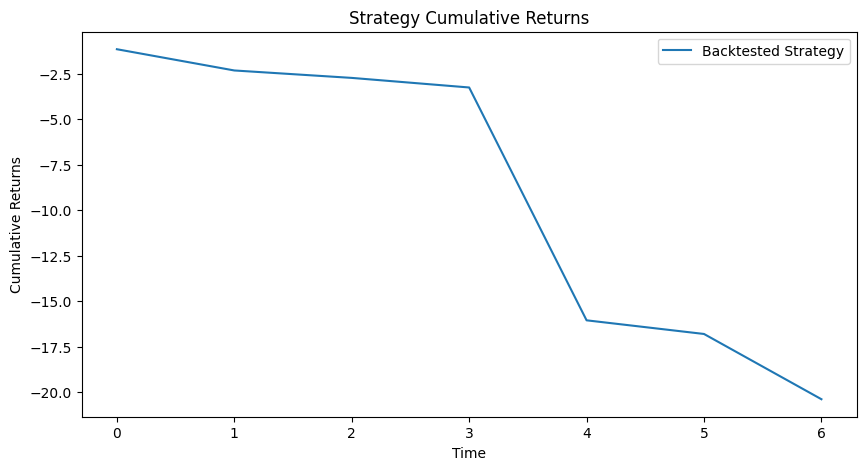

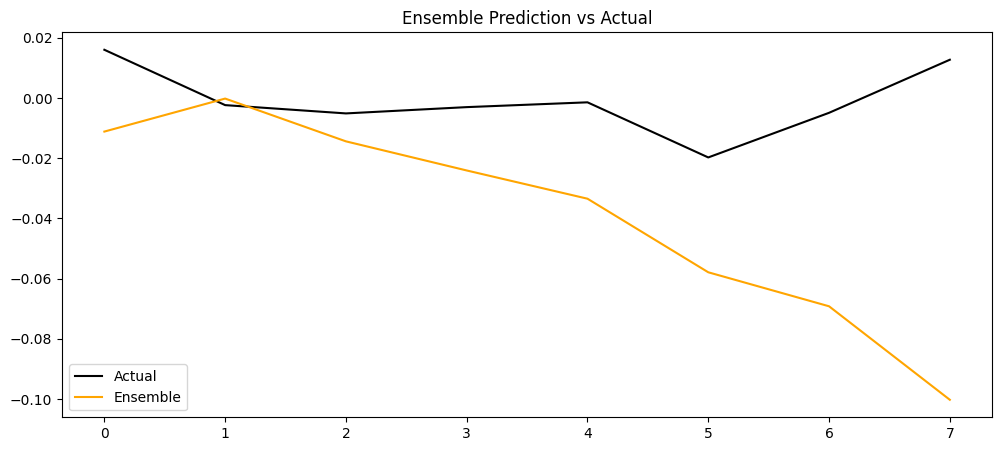

In [8]:
# -------------------------
# Demo: Next Steps on saved outputs
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib
import shap

# Path to results
RESULTS_DIR = 'results_archive'

# -------------------------
# 1. Load saved predictions CSV for one ticker (example: AAPL)
# -------------------------
csv_file = os.path.join(RESULTS_DIR, 'AAPL_preds.csv')
df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

y_test = df['y_test'].values
X_train = np.array(df[['lr_pred','rf_pred','gbr_pred']])  # example features

# -------------------------
# 2. Hyperparameter tuning for RandomForest / GBR
# -------------------------
def tune_classical_model(X, y, model_name='RandomForest'):
    tscv = TimeSeriesSplit(n_splits=3)
    if model_name=='RandomForest':
        model = RandomForestRegressor(random_state=42)
        params = {'n_estimators':[50,100], 'max_depth':[3,5, None]}
    else:
        model = GradientBoostingRegressor(random_state=42)
        params = {'n_estimators':[50,100], 'learning_rate':[0.01,0.1], 'max_depth':[3,5]}
    gsearch = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error')
    gsearch.fit(X, y)
    print(f"Best params for {model_name}: {gsearch.best_params_}")
    return gsearch.best_estimator_

rf_tuned = tune_classical_model(X_train, y_test, 'RandomForest')
gbr_tuned = tune_classical_model(X_train, y_test, 'GradientBoosting')

# -------------------------
# 3. Feature importance using SHAP
# -------------------------
explainer = shap.Explainer(rf_tuned, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=['LR','RF','GBR'])

# -------------------------
# 4. Multi-variate LSTM preparation (demo)
# -------------------------
# Normally you use features dataframe + target
def prepare_multivariate_lstm(features_df, target_col, seq_len=20):
    data = features_df.values
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, features_df.columns.get_loc(target_col)])
    return np.array(X), np.array(y)
# Example: X_mv, y_mv = prepare_multivariate_lstm(features_df, 'AAPL')

# -------------------------
# 5. Backtesting demo
# -------------------------
def backtest_strategy(y_true, y_pred):
    returns = np.diff(y_true)/y_true[:-1]
    pred_sign = np.sign(np.diff(y_pred))
    strategy_returns = returns * pred_sign
    cumulative = np.cumsum(strategy_returns)
    plt.figure(figsize=(10,5))
    plt.plot(cumulative, label='Backtested Strategy')
    plt.title('Strategy Cumulative Returns')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

backtest_strategy(y_test, df['rf_pred'].values)

# -------------------------
# 6. Ensemble predictions
# -------------------------
def ensemble_predictions(preds_dict, weights=None):
    names = list(preds_dict.keys())
    if weights is None:
        weights = [1/len(names)]*len(names)
    ensemble = np.zeros_like(list(preds_dict.values())[0])
    for i,name in enumerate(names):
        ensemble += preds_dict[name]*weights[i]
    return ensemble

preds_dict = {
    'LR': df['lr_pred'].values,
    'RF': df['rf_pred'].values,
    'GBR': df['gbr_pred'].values
}

ensemble_pred = ensemble_predictions(preds_dict)
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual', color='black')
plt.plot(ensemble_pred, label='Ensemble', color='orange')
plt.title('Ensemble Prediction vs Actual')
plt.legend()
plt.show()


**Install packages (once per session):**

In [38]:
%pip install streamlit
%pip install plotly



Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


**Write your app.py:**

In [ ]:
%%Writefile app.py

import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime, timedelta

# -------------------------------
# App Layout
# -------------------------------
st.set_page_config(page_title="Stock Prediction Dashboard", layout="wide")
st.title("📈 Stock Prediction & Analysis Dashboard")
st.write("Real-time stock data, charts, and analysis with ML predictions")
st.write("Welcome! This app will show real-time predictions with charts.")

# -------------------------------
# Sidebar Inputs (Single Ticker)
# -------------------------------
st.sidebar.header("Select Stock")
ticker = st.sidebar.text_input("Enter Stock Symbol (e.g. AAPL, TSLA, MSFT)", "AAPL")

start_date = st.sidebar.date_input("Start Date", datetime.today() - timedelta(days=365))
end_date = st.sidebar.date_input("End Date", datetime.today())
ma1 = st.sidebar.slider("Short-term Moving Average (days)", 5, 50, 20)
ma2 = st.sidebar.slider("Long-term Moving Average (days)", 50, 200, 100)

# Optional: quick refresh button (not true realtime; grabs latest on click)
if st.sidebar.button("🔄 Refresh data"):
    st.cache_data.clear()

# -------------------------------
# Helpers
# -------------------------------
def _ensure_single_level_columns(df: pd.DataFrame) -> pd.DataFrame:
    """If yfinance returns a MultiIndex (e.g., ('Close','AAPL')), flatten to single level."""
    if isinstance(df.columns, pd.MultiIndex):
        # keep only the first level names: Open, High, Low, Close, Adj Close, Volume
        df = df.copy()
        df.columns = df.columns.get_level_values(0)
    return df

def _col_series(df: pd.DataFrame, name: str) -> pd.Series:
    """Return a 1D Series for a given column name even if df[name] is a 1-col DataFrame."""
    col = df[name]
    if isinstance(col, pd.DataFrame):
        col = col.iloc[:, 0]
    return pd.to_numeric(col, errors="coerce")

@st.cache_data
def load_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end, progress=False, auto_adjust=False, actions=False)
    if df is None or df.empty:
        return pd.DataFrame()
    df = _ensure_single_level_columns(df)
    # make sure index is tz-naive (sometimes yfinance returns tz-aware)
    try:
        df.index = df.index.tz_localize(None)
    except Exception:
        pass
    return df

# -------------------------------
# Fetch Data (Single Ticker)
# -------------------------------
data = load_data(ticker, start_date, end_date)

if data.empty:
    st.error("No data found! Check ticker symbol or date range.")
    st.stop()

# Extract Series for OHLC to avoid MultiIndex assignment issues
open_s  = _col_series(data, "Open")
high_s  = _col_series(data, "High")
low_s   = _col_series(data, "Low")
close_s = _col_series(data, "Close")
vol_s   = _col_series(data, "Volume")

# Precompute common fields
data[f"MA{ma1}"] = close_s.rolling(ma1).mean()
data[f"MA{ma2}"] = close_s.rolling(ma2).mean()
data["Returns"]  = close_s.pct_change()

# -------------------------------
# Tabs
# -------------------------------
tab1, tab2, tab3, tab4 = st.tabs([
    "📊 Price Charts",
    "📉 Technical Indicators",
    "📈 Returns & Risk",
    "ℹ️ Metrics"
])

# -------------------------------
# Tab 1: Price Charts
# -------------------------------
with tab1:
    st.subheader(f"{ticker} — Line & Candlestick with Moving Averages")

    # Line Chart
    fig_line = go.Figure()
    fig_line.add_trace(go.Scatter(x=data.index, y=close_s, mode='lines', name='Close'))
    fig_line.add_trace(go.Scatter(x=data.index, y=data[f"MA{ma1}"], mode='lines', name=f'{ma1}-Day MA'))
    fig_line.add_trace(go.Scatter(x=data.index, y=data[f"MA{ma2}"], mode='lines', name=f'{ma2}-Day MA'))
    fig_line.update_layout(hovermode="x unified", margin=dict(l=10, r=10, t=30, b=10))
    st.plotly_chart(fig_line, use_container_width=True)

    # Candlestick + MAs
    fig_candle = go.Figure(data=[go.Candlestick(
        x=data.index, open=open_s, high=high_s, low=low_s, close=close_s, name="Candlestick"
    )])
    fig_candle.add_trace(go.Scatter(x=data.index, y=data[f"MA{ma1}"], mode='lines', name=f'{ma1}-Day MA'))
    fig_candle.add_trace(go.Scatter(x=data.index, y=data[f"MA{ma2}"], mode='lines', name=f'{ma2}-Day MA'))
    fig_candle.update_layout(xaxis_rangeslider_visible=False, hovermode="x unified",
                             margin=dict(l=10, r=10, t=30, b=10))
    st.plotly_chart(fig_candle, use_container_width=True)

# -------------------------------
# Tab 2: Technical Indicators
# -------------------------------
with tab2:
    st.subheader(f"{ticker} — RSI, MACD, Bollinger Bands")

    # --- RSI (14) ---
    delta = close_s.diff()
    gain = delta.where(delta > 0, 0.0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(14).mean()
    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    data["RSI"] = rsi

    # --- MACD (12,26,9) ---
    ema12 = close_s.ewm(span=12, adjust=False).mean()
    ema26 = close_s.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    data["MACD"] = macd
    data["Signal"] = signal

    # --- Bollinger Bands (20, 2σ) ---
    ma20 = close_s.rolling(20).mean()
    std20 = close_s.rolling(20).std()
    data["20MA"] = ma20
    data["Upper"] = ma20 + std20 * 2
    data["Lower"] = ma20 - std20 * 2

    # Plot Bollinger Bands with price
    fig_bb = go.Figure()
    fig_bb.add_trace(go.Scatter(x=data.index, y=close_s, mode='lines', name='Close'))
    fig_bb.add_trace(go.Scatter(x=data.index, y=data["Upper"], line=dict(dash='dot'), name='Upper BB'))
    fig_bb.add_trace(go.Scatter(x=data.index, y=data["Lower"], line=dict(dash='dot'), name='Lower BB'))
    fig_bb.update_layout(hovermode="x unified", margin=dict(l=10, r=10, t=30, b=10))
    st.plotly_chart(fig_bb, use_container_width=True)

    # RSI line
    st.line_chart(data["RSI"], height=220, use_container_width=True)

    # MACD vs Signal
    st.line_chart(data[["MACD", "Signal"]], height=220, use_container_width=True)

# -------------------------------
# Tab 3: Returns & Risk
# -------------------------------
with tab3:
    st.subheader(f"{ticker} — Returns & Risk")

    # Daily returns distribution
    fig, ax = plt.subplots()
    sns.histplot(data["Returns"].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(f"{ticker} Daily Returns Distribution")
    st.pyplot(fig)

    # Rolling 20-day volatility (std of returns)
    data["RollVol20"] = data["Returns"].rolling(20).std() * np.sqrt(252)
    st.line_chart(data["RollVol20"], height=220, use_container_width=True)

    # Cumulative returns
    cumret = (1 + data["Returns"].fillna(0)).cumprod() - 1
    st.line_chart(cumret, height=220, use_container_width=True)

    # OHLC correlation (single ticker)
    st.subheader("Correlation Matrix (OHLCV)")
    fig_corr, axc = plt.subplots()
    corr_df = data[["Open", "High", "Low", "Close", "Volume"]].apply(pd.to_numeric, errors="coerce").corr()
    sns.heatmap(corr_df, annot=True, cmap="coolwarm", ax=axc)
    st.pyplot(fig_corr)

# -------------------------------
# Tab 4: Performance Metrics
# -------------------------------
with tab4:
    st.subheader(f"{ticker} — Key Metrics")

    latest_close = float(close_s.dropna().iloc[-1])

    avg_return = float(data["Returns"].mean() * 100)
    volatility = float(data["Returns"].std() * np.sqrt(252) * 100)  # annualized
    total_volume = int(vol_s.sum())

    # Max Drawdown
    cum = (1 + data["Returns"].fillna(0)).cumprod()
    running_max = cum.cummax()
    drawdown = (cum / running_max) - 1
    max_dd = float(drawdown.min() * 100)

    col1, col2, col3, col4 = st.columns(4)
    col1.metric("Latest Closing Price", f"${latest_close:.2f}")
    col2.metric("Avg Daily Return", f"{avg_return:.2f}%")
    col3.metric("Annualized Volatility", f"{volatility:.2f}%")
    col4.metric("Total Volume Traded", f"{total_volume:,}")

    st.caption(f"Max Drawdown: **{max_dd:.2f}%**")

# -------------------------------
# Footer / Info
# -------------------------------
st.info("🚀 This dashboard can be extended with ML predictions using models saved in `results_archive/`. For now, it shows analytics & visualization.")


**Save your Colab code into app.py locally**

**. Download app.py from Colab**

In [47]:
#from google.colab import files
#files.download("app.py")


**Run Streamlit locally**

In [10]:
import os

results_path = 'C:\\Users\\Tanisha\\Downloads\\stock-app\\results_archive (1)'
print(os.listdir(results_path))


['.ipynb_checkpoints', 'AAPL_GradientBoosting.joblib', 'AAPL_LinearRegression.joblib', 'AAPL_lstm.h5', 'AAPL_predictions.png', 'AAPL_preds.csv', 'AAPL_RandomForest.joblib', 'AAPL_scaler.joblib', 'adj_close.csv', 'features.csv', 'GOOGL_GradientBoosting.joblib', 'GOOGL_LinearRegression.joblib', 'GOOGL_lstm.h5', 'GOOGL_predictions.png', 'GOOGL_preds.csv', 'GOOGL_RandomForest.joblib', 'GOOGL_scaler.joblib', 'models_summary.csv', 'MSFT_GradientBoosting.joblib', 'MSFT_LinearRegression.joblib', 'MSFT_lstm.h5', 'MSFT_predictions.png', 'MSFT_preds.csv', 'MSFT_RandomForest.joblib', 'MSFT_scaler.joblib', 'NFLX_GradientBoosting.joblib', 'NFLX_LinearRegression.joblib', 'NFLX_lstm.h5', 'NFLX_predictions.png', 'NFLX_preds.csv', 'NFLX_RandomForest.joblib', 'NFLX_scaler.joblib', 'price_matrix.png', 'price_trends.png', 'returns_correlation.png']


**Step 1: Zip all files in the results_archive folder**

In [44]:
import shutil

# Path to the results folder
results_path = 'C:\\Users\\Tanisha\\Downloads\\stock-app\\results_archive (1)'

# Zip all files into one archive
shutil.make_archive(results_path, 'zip', results_path)


'C:\\Users\\Tanisha\\Downloads\\stock-app\\results_archive (1).zip'

**Step 2: Download the zip to your Windows machine**

In [ ]:
#from google.colab import files

#files.download('/content/results_archive.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import plotly
print(plotly.__version__)


6.3.0
